# Step 03
# Predict segmentations

In [1]:
%matplotlib inline

In [2]:
import os
import os.path

import matplotlib.pyplot as plt
import numpy as np

import skimage.io
import skimage.morphology
import skimage.util

import tensorflow as tf
import keras

import utils.metrics
import utils.model_builder

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


# Configuration

In [3]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
partition = "test"

experiment_name = '09'

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars

{'augment_images': False,
 'batch_size': 10,
 'boundary_boost_factor': 1,
 'boundary_labels_dir': '/data1/image-segmentation/dsb_eval/boundary_labels/',
 'boundary_size': 2,
 'cell_min_size': 16,
 'create_split_files': False,
 'crop_size': 256,
 'csv_log_file': '/data1/image-segmentation/dsb_eval/experiments/09/log.csv',
 'elastic_augmentations': 10,
 'elastic_distortion': 5,
 'elastic_points': 16,
 'epochs': 50,
 'experiment_dir': '/data1/image-segmentation/dsb_eval/experiments/09/out/',
 'labels_out_dir': '/data1/image-segmentation/dsb_eval/experiments/09/out/segm/',
 'learning_rate': 0.0001,
 'max_training_images': 0,
 'min_nucleus_size': 5,
 'model_file': '/data1/image-segmentation/dsb_eval/experiments/09/model.hdf5',
 'normalized_images_dir': '/data1/image-segmentation/dsb_eval/norm_images/',
 'object_dilation': 3,
 'path_files_test': '/data1/image-segmentation/dsb_eval/test.txt',
 'path_files_training': '/data1/image-segmentation/dsb_eval/training.txt',
 'path_files_validation': 

In [4]:
# Device configuration

# Use the following configuration if you want to test on CPUs
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# configuration = tf.ConfigProto(
#       intra_op_parallelism_threads=1,
#       inter_op_parallelism_threads=1)

# Configuration to run on GPU
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"

session = tf.Session(config = configuration)

# apply session
keras.backend.set_session(session)

# Auxiliary functions

In [5]:
def preprocess(image):
    im = np.zeros_like(image)
    # preprocess (assuming images are encoded as 8-bits in the preprocessing step)
    for i in range(image.shape[2]):
        im[:,:,i] = skimage.exposure.adjust_log(image[:,:,i], 1)
        
#     im = skimage.filters.gaussian(im, sigma=12, preserve_range=True)
        
    gray = skimage.color.rgb2gray(im)
    gray = np.repeat(gray[:,:,np.newaxis], 3, axis=2)
    gray = skimage.util.invert(im)
    im = gray / 255
    
    return im

def multiscale(image):
    d1,d2,c = image.shape
    grid1 = [0, d1//4, d1//2, 3*d1//4, d1]
    grid2 = [0, d2//4, d2//2, 3*d2//4, d2]
    im = preprocess(image)
    scales = [im[np.newaxis,:,:,:]]
    
    for i in range(len(grid1)-2):
        for j in range(len(grid2)-2):
            sub_image = image[grid1[i]:grid1[i+2], grid2[j]:grid2[j+2]]
            sub_image = skimage.transform.rescale(sub_image, 2)
            scales.append(sub_image[np.newaxis,:,:,:])
            
    return scales[0]
    #return np.concatenate(scales, axis=0)

def one_hot(prob_map):
    max_pred = np.argmax(prob_map, axis=2)
    oh = np.zeros_like(prob_map)
    for i in range(oh.shape[2]):
        oh[:,:,i] = max_pred == i
    return oh

def stitch(scales, votes=False):
    return scales[0,...]
    batch, d1, d2, ch = scales.shape
    stitched = np.zeros_like(scales[0,...])
    if votes:
        stitched += one_hot(scales[0,...])
    else:
        stitched += scales[0,...]
    
    grid1 = [0, d1//4, d1//2, 3*d1//4, d1]
    grid2 = [0, d2//4, d2//2, 3*d2//4, d2]
    
    sub_idx = 1
    for i in range(len(grid1)-2):
        for j in range(len(grid2)-2):
            downscaled = skimage.transform.rescale(scales[sub_idx,...], 0.5)
            if votes:
                downscaled = one_hot(downscaled)
            stitched[grid1[i]:grid1[i+2], grid2[j]:grid2[j+2], :] += downscaled
            sub_idx += 1
    
    factors = [2,3,3,2, 3,5,5,3, 3,5,5,3, 2,3,3,2]
    #factors = [1,2,2,1, 2,4,4,2, 2,4,4,2, 1,2,2,1]
    for i in range(len(grid1)-1):
        for j in range(len(grid2)-1):
            stitched[grid1[i]:grid1[i+1],grid2[j]:grid2[j+1]] /= factors[j+4*i]
            
    #return stitched

# Load images and run predictions

In [6]:
# build model and load weights
model = utils.model_builder.get_model_3_class(None, None)
model.load_weights(config_vars["model_file"])
    
image_names = [os.path.join(config_vars["normalized_images_dir"], f) for f in data_partitions[partition]]

imagebuffer = skimage.io.imread_collection(image_names)
predictions = []

for i in range(len(imagebuffer)):
    image = imagebuffer[i]

    dim1 = image.shape[0]
    dim2 = image.shape[1]
    
    expand = 8
    h_exp = expand - dim1%expand
    w_exp = expand - dim2%expand
    dim1 = dim1 + h_exp
    dim2 = dim2 + w_exp
    
    if len(image.shape) == 2:
        image = skimage.color.gray2rgb(image)
    image = image[:,:,0:3]
    image = skimage.util.pad(image, [(h_exp, 0), (w_exp, 0), (0,0)], "edge")

    # Normal prediction time
    scales = multiscale(image)
    p = model.predict(scales, batch_size=1)
    predictions.append({"pred":p, "h_exp":h_exp, "w_exp":w_exp, "scales":scales})
    

/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


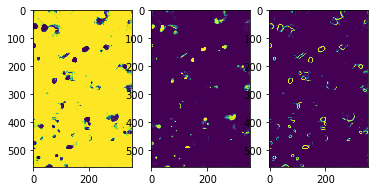

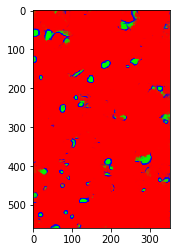

In [7]:
together = stitch(p)
f,ax = plt.subplots(1,3)
for i in range(3): ax[i].imshow(together[:,:,i])
plt.show()
plt.imshow(together)
plt.show()

# Transform predictions to label matrices

39b6ed3e0dd50ea6e113e4f95b656c9bdc6d3866579f648a16a853aeb5af1a61.png
103 103


/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/morphology/misc.py:207: UserWarning: the min_size argument is deprecated and will be removed in 0.16. Use area_threshold instead.
  "0.16. Use area_threshold instead.")
/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /data1/image-segmentation/dsb_eval/experiments/09/out/segm/39b6ed3e0dd50ea6e113e4f9

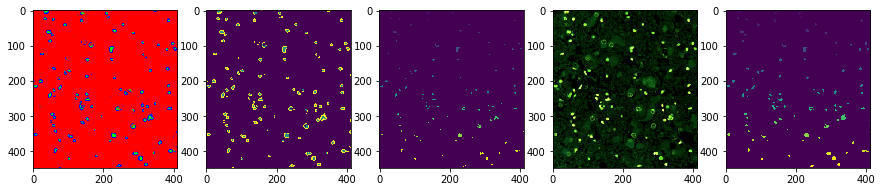

8b80aca225c1dd0aa5637229f0e0bec0dbd7b5313b462effd768da2bb5a56a06.png
84 84


/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /data1/image-segmentation/dsb_eval/experiments/09/out/segm/8b80aca225c1dd0aa5637229f0e0bec0dbd7b5313b462effd768da2bb5a56a06.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


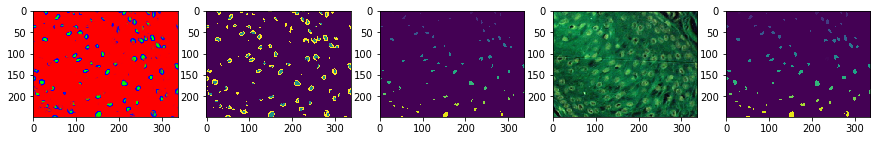

e476039d612f9e94797ad3fa8f8ee90c040c7609a83c53c974818ddc38bd7e47.png
209 209


/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /data1/image-segmentation/dsb_eval/experiments/09/out/segm/e476039d612f9e94797ad3fa8f8ee90c040c7609a83c53c974818ddc38bd7e47.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


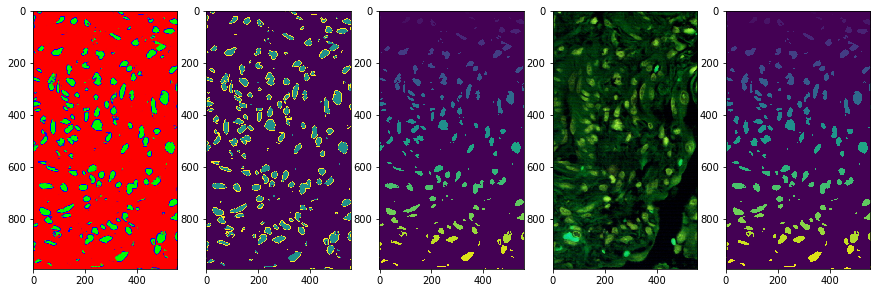

f22874c8fac3c7c39297796cf8e03f1b5c18a1a2497973ae9338f7f7dd46d36b.png
42 42


/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /data1/image-segmentation/dsb_eval/experiments/09/out/segm/f22874c8fac3c7c39297796cf8e03f1b5c18a1a2497973ae9338f7f7dd46d36b.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


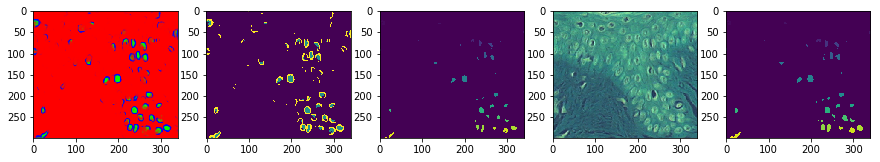

f6f5ddbd961a34a4df6cafe379e6070ca6c6465b0193ab9476245397b3d28c28.png
62 62


/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /data1/image-segmentation/dsb_eval/experiments/09/out/segm/f6f5ddbd961a34a4df6cafe379e6070ca6c6465b0193ab9476245397b3d28c28.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


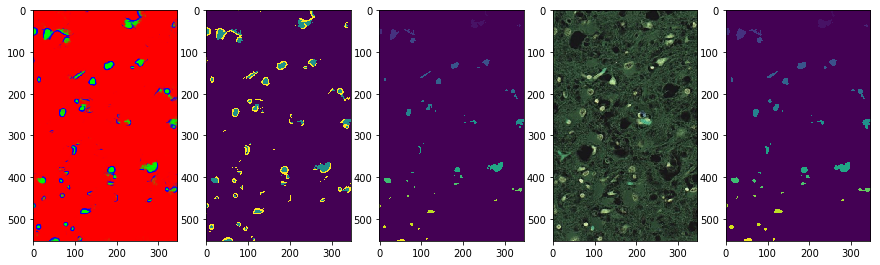

In [8]:
import skimage.morphology.watershed

for i in range(len(predictions)):

    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = stitch(predictions[i]["pred"], votes=False)
    probmap = probmap[predictions[i]["h_exp"]:,predictions[i]["w_exp"]:,:]
    image = predictions[i]["scales"][0,predictions[i]["h_exp"]:,predictions[i]["w_exp"]:,:]
    
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])
    
    label = utils.metrics.pred_to_label(pred, 0)#config_vars["cell_min_size"])
  
    # Apply watershed
    new_labels = skimage.morphology.watershed((pred > 0), label)
    new_labels = skimage.measure.label(new_labels)
    missing_object = (new_labels==1)*(label)
    new_labels[new_labels == 1] = 0
    new_labels[missing_object > 0] = 1
    
    # Object size priors:
#     cell1 = skimage.morphology.remove_small_objects(new_labels > 0, min_size=1000)
#     new_labels = new_labels * cell1
#     new_labels = skimage.morphology.closing(new_labels, selem=skimage.morphology.disk(20))
    
    print(len(np.unique(label)), len(np.unique(new_labels)))
    
    skimage.io.imsave(config_vars["labels_out_dir"] + filename.replace(".png", ".tiff"), new_labels)
    
    f, ax = plt.subplots(1,5)
    f.set_size_inches(15, 15)
    ax[0].imshow(probmap)
    ax[1].imshow(pred)
    ax[2].imshow(label)
    ax[3].imshow(image)
    ax[4].imshow(new_labels)
    plt.show()  

In [9]:
# import matplotlib.pyplot as plt
# import skimage.io
# import pandas as pd
# import skimage.filters 
# import skimage.morphology

In [10]:
# def scale_annotation(gt):
#     categories = np.argmax(gt, axis=2)
#     annot = (categories[:,:] == 1)/1. # + (categories[:,:] == 2)/1.
#     boundaries = skimage.segmentation.find_boundaries(skimage.measure.label(annot), connectivity=1, mode="outer")
#     annot = (annot + boundaries)>0
#     boundaries = skimage.segmentation.find_boundaries(skimage.measure.label(annot), connectivity=1, mode="outer")
#     boundaries = skimage.morphology.binary_dilation(boundaries, selem=skimage.morphology.square(2))
    
#     binary_labels = np.zeros((annot.shape + (3,)))
#     binary_labels[(annot == 0) & (boundaries == 0), 0] = 1
#     binary_labels[(annot != 0) & (boundaries == 0), 1] = 1
#     binary_labels[boundaries == 1, 2] = 1
    
#     return binary_labels

In [11]:
# df = pd.read_csv("/data1/image-segmentation/dsb_eval/validation.txt", header=None)
# for k,r in df.iterrows():
#     im = skimage.io.imread("/data1/image-segmentation/dsb_eval/norm_images/" + r[0])
#     if im.shape[2] > 3: im = im[:,:,0:3]
#     gt = skimage.io.imread("/data1/image-segmentation/dsb_eval/boundary_labels/" + r[0])#.replace(".png",".tiff"))
#     eq = np.zeros_like(im)
# #     for i in range(eq.shape[2]):
# #         p1, p99 = np.percentile(im[:,:,i], (1, 99))
# #         eq[:,:,i] = skimage.exposure.rescale_intensity(im[:,:,i], in_range=(p1, p99))
        
#     #gray = skimage.color.rgb2gray(eq)
#     #gray = np.repeat(gray[:,:,np.newaxis], 3, axis=2)
#     #gray = skimage.util.invert(gray)
    
#     #http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.separate_stains
#     gray = skimage.color.separate_stains(im, skimage.color.bro_from_rgb)
#     gray = skimage.exposure.rescale_intensity(gray[:,:,0], out_range=(0,1))
#     gray = np.repeat(gray[:,:,np.newaxis], 3, axis=2)
    
#     src = gt#[128:256,128:256]
#     xp = skimage.transform.rescale(src,2,anti_aliasing=False)
#     label_binary = scale_annotation(xp)
    
#     f, axes = plt.subplots(1,4)
#     f.set_size_inches(20,20)
#     axes[0].imshow(im)
#     axes[1].imshow(gray)
#     axes[2].imshow(src)
#     axes[3].imshow(label_binary)
#     plt.show()
    